In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from skbio import DistanceMatrix

plt.style.use("./paper.mplstyle")

In [2]:
df_orig = pd.read_table("../data/ref/ag_map_with_alpha.txt.quartiles.tsv", sep="\t", index_col=0)
df_orig.index = "S" + df_orig.index
print(df_orig.shape)
df_orig.head()

(9511, 146)


,center_project_name,extraction_robot,plating,primer_plate,processing_robot,acid_reflux,acne_medication_otc,add_adhd,age_cat,alcohol_consumption,...,vioscreen_erythr,vioscreen_fiber,vioscreen_fol_deqv,vioscreen_formontn,vioscreen_grams,vioscreen_inositol,vioscreen_lutzeax,vioscreen_lycopene,vioscreen_tfa181t,vioscreen_xylitol
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000028848,AG19,NaN,NaN,NaN,NaN,NaN,Yes,"Diagnosed by a medical professional (doctor, p...",30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000049761,NaN,NaN,NaN,5.0,ROBE,I do not have this condition,No,I do not have this condition,50s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000059054,NaN,HOWE_KF1,LDG,7.0,CARMEN,I do not have this condition,No,I do not have this condition,60s,Yes,...,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0
S10317.000030512,AG25,HOWE_KF2,LDG,6.0,JERE,NaN,No,I do not have this condition,30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000040165,NaN,HOWE_KF1,LDG,5.0,ROBE,NaN,No,I do not have this condition,30s,Yes,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0


In [3]:
## Remap since some failed

cond_map = {
    "I do not have this condition": "No",
    "Diagnosed by a medical professional (doctor, physician assistant)": "Yes",
    "Self-diagnosed": np.nan,
    "Diagnosed by an alternative medicine practitioner": np.nan,
}

def replace_cond(item_1):
    if item_1 in cond_map:
        return cond_map[item_1]
    else:
        return item_1
    
q_map = {0.0: "q1", 1.0: "q2", 2.0: "q3", 3.0: "q4"}
    
for col in df_orig:
    df_orig[col] = df_orig[col].map(replace_cond)
    if set(df_orig[col].dropna().unique()) == {0.0, 1.0, 2.0, 3.0}:
        df_orig[col] = df_orig[col].map(q_map)

print(df_orig.shape)

(9511, 146)


In [4]:
agp_results = pd.read_excel(
    "../data/ref/sys003182229st2.xlsx",
    sheet_name="Effect size, unweighted UniFrac",
    header=0
)
agp_results[["group_1", "group_2"]] = agp_results["effect_size_values"].str.split(" vs. ", expand=True)
q_map = {"0.0": "q1", "1.0": "q2", "2.0": "q3", "3.0": "q4"}
agp_results["group_1"] = agp_results["group_1"].replace(q_map)
agp_results["group_2"] = agp_results["group_2"].replace(q_map)

agp_results["group_1"] = agp_results["group_1"].map(replace_cond)
agp_results["group_2"] = agp_results["group_2"].map(replace_cond)

agp_results = agp_results.replace({"Child": "child"})

print(agp_results.shape)
agp_results.head()

(113, 8)


,column_name,effect_size,effect_size_square,effect_size_values,pval_corrected,pval,group_1,group_2
0,age_cat,0.616142,0.379631,Child vs. 60s,0.000323,0.0002,child,60s
1,center_project_name,0.497663,0.247668,AG1 vs. AG23,0.000323,0.0002,AG1,AG23
2,antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.
3,processing_robot,0.387074,0.149826,RikE vs. LUCY,0.000323,0.0002,RikE,LUCY
4,prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never


In [5]:
na_vals = ["Not provided"]
df_new = pd.read_table("../data/processed/metadata.disambig.filt.tsv", sep="\t", index_col=0,
                       na_values=na_vals)
print(df_new.shape)
df_new.head()

(9511, 89)


,fermented_plant_frequency,seasonal_allergies,processing_robot,cardiovascular_disease,non_food_allergies_sun,tonsils_removed,specialized_diet_exclude_refined_sugars,lactose,flu_vaccine_date,mental_illness_type_ptsd_posttraumatic_stress_disorder,...,vegetable_frequency,contraceptive,autoimmune,chickenpox,olive_oil,multivitamin,acne_medication_otc,last_travel,teethbrushing_frequency,center_project_name
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000046293.134355,Never,Yes,ROBE,No,No,Yes,No,No,I have not gotten the flu vaccine in the past ...,No,...,Daily,"Yes, I am taking the ""pill",Yes,Yes,Daily,No,No,3 months,Daily,AG31
S10317.000028098.130493,Rarely (less than once/week),Yes,ROBE,No,No,No,No,No,I have not gotten the flu vaccine in the past ...,No,...,Daily,No,No,Yes,Regularly (3-5 times/week),No,No,I have not been outside of my country of resid...,Daily,AG22
S10317.000013846.129675,Rarely (less than once/week),Yes,ROBE,No,No,No,No,No,Year,No,...,Occasionally (1-2 times/week),"Yes, I am taking the ""pill",No,Yes,Occasionally (1-2 times/week),No,No,I have not been outside of my country of resid...,Daily,AG34
S10317.000004886.131501,NaN,No,JERE,NaN,No,No,No,No,I have not gotten the flu vaccine in the past ...,No,...,NaN,NaN,NaN,Yes,NaN,Yes,No,3 months,Daily,AG13
S10317.000031515.130493,Occasionally (1-2 times/week),No,ROBE,No,No,No,No,No,Year,No,...,Regularly (3-5 times/week),No,No,Yes,Occasionally (1-2 times/week),Yes,No,3 months,Daily,AG22


In [6]:
set(agp_results["column_name"]).difference(df_new.columns)

{'age_cat',
 'alcohol_consumption',
 'alcohol_types_beercider',
 'alcohol_types_red_wine',
 'alcohol_types_spiritshard_alcohol',
 'alcohol_types_white_wine',
 'allergic_to_i_have_no_food_allergies_that_i_know_of',
 'bmi_corrected',
 'census_region',
 'collection_month',
 'country',
 'elevation',
 'height_cm',
 'latitude',
 'longitude',
 'plating',
 'roommates',
 'vioscreen_a_bev',
 'vioscreen_add_sug',
 'vioscreen_alphacar',
 'vioscreen_alphtoce',
 'vioscreen_avcarb',
 'vioscreen_betacryp',
 'vioscreen_biochana',
 'vioscreen_caffeine',
 'vioscreen_calcium',
 'vioscreen_copper',
 'vioscreen_d_cheese',
 'vioscreen_erythr',
 'vioscreen_f_citmlb',
 'vioscreen_fiber',
 'vioscreen_fol_deqv',
 'vioscreen_formontn',
 'vioscreen_g_whl',
 'vioscreen_grams',
 'vioscreen_inositol',
 'vioscreen_lutzeax',
 'vioscreen_lycopene',
 'vioscreen_m_fish_hi',
 'vioscreen_m_frank',
 'vioscreen_m_meat',
 'vioscreen_m_mpf',
 'vioscreen_salad_vegetable_servings',
 'vioscreen_tfa181t',
 'vioscreen_xylitol',
 'we

In [7]:
set(df_new.columns).difference(agp_results["column_name"])

{'allergic_to_shellfish',
 'artificial_sweeteners',
 'cancer',
 'cardiovascular_disease',
 'country_of_birth',
 'dominant_hand',
 'lung_disease',
 'mental_illness',
 'mental_illness_type_ptsd_posttraumatic_stress_disorder',
 'migraine',
 'non_food_allergies_beestings',
 'non_food_allergies_drug_eg_penicillin',
 'non_food_allergies_pet_dander',
 'non_food_allergies_poison_ivyoak',
 'non_food_allergies_sun',
 'pets_other',
 'skin_condition',
 'smoking_frequency',
 'specialized_diet_exclude_refined_sugars',
 'specialized_diet_modified_paleo_diet',
 'specialized_diet_other_restrictions_not_described_here',
 'vivid_dreams'}

In [8]:
common_cols = set(df_new.columns).intersection(agp_results["column_name"])

In [9]:
pw_new = pd.read_table("../results/beta_pairwise_effect_size_by_cat.tsv",
                       sep="\t", index_col=0).dropna()

pw_new["group_1"] = pw_new["group_1"].replace({"Child": "child"})
pw_new["group_2"] = pw_new["group_2"].replace({"Child": "child"})

_dfs = []
for i, row in agp_results.iterrows():
    g1, g2 = row[["group_1", "group_2"]]
    x = pw_new[
        (((pw_new["group_1"] == g1) & (pw_new["group_2"] == g2))
        | ((pw_new["group_1"] == g2) & (pw_new["group_2"] == g1)))
        & (pw_new["column"] == row["column_name"])
    ]
    _dfs.append(x)
    
evident_df_new = pd.concat(_dfs).reset_index(drop=True)
print(evident_df_new.shape)
evident_df_new.head()

(60, 5)


,effect_size,metric,column,group_1,group_2
0,0.405544,cohens_d,antibiotic_history,I have not taken antibiotics in the past year.,Month
1,0.359248,cohens_d,prepared_meals_frequency,Never,Occasionally (1-2 times/week)
2,0.299894,cohens_d,race,Asian or Pacific Islander,Caucasian
3,0.310344,cohens_d,salted_snacks_frequency,Never,Regularly (3-5 times/week)
4,0.292891,cohens_d,sugary_sweets_frequency,Never,Regularly (3-5 times/week)


In [10]:
comp_df_agp_new = (
    agp_results.set_index("column_name")
    .join(evident_df_new.set_index("column"), lsuffix="_agp", rsuffix="_evident", how="inner")
)
comp_df_agp_new["es_diff"] = comp_df_agp_new["effect_size_agp"] - comp_df_agp_new["effect_size_evident"]
comp_df_agp_new["es_diff_abs"] = np.abs(comp_df_agp_new["es_diff"])
comp_df_agp_new = comp_df_agp_new.sort_values(by="effect_size_evident", ascending=False)
print(comp_df_agp_new.shape)
comp_df_agp_new.head(10)

(60, 13)


,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.,0.405544,cohens_d,I have not taken antibiotics in the past year.,Month,-0.016596,0.016596
prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.359248,cohens_d,Never,Occasionally (1-2 times/week),0.016100,0.016100
salted_snacks_frequency,0.345779,0.119563,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.310344,cohens_d,Never,Regularly (3-5 times/week),0.035434,0.035434
types_of_plants,0.298036,0.088826,Less than 5 vs. More than 30,0.000323,0.0002,Less than 5,More than 30,0.307845,cohens_d,Less than 5,More than 30,-0.009808,0.009808
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.299894,cohens_d,Asian or Pacific Islander,Caucasian,0.066133,0.066133
sugary_sweets_frequency,0.335986,0.112887,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.292891,cohens_d,Never,Regularly (3-5 times/week),0.043095,0.043095
fruit_frequency,0.305122,0.093100,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.273028,cohens_d,Never,Occasionally (1-2 times/week),0.032094,0.032094
fungal_overgrowth,0.290273,0.084258,"Diagnosed by a medical professional (doctor, p...",0.000323,0.0002,Yes,No,0.257566,cohens_d,No,Yes,0.032707,0.032707
bowel_movement_frequency,0.288244,0.083085,Less than one vs. Four or more,0.000323,0.0002,Less than one,Four or more,0.245310,cohens_d,Four or more,Less than one,0.042934,0.042934
last_travel,0.210709,0.044398,3 months vs. I have not been outside of my cou...,0.000323,0.0002,3 months,I have not been outside of my country of resid...,0.244533,cohens_d,3 months,I have not been outside of my country of resid...,-0.033824,0.033824


In [11]:
comp_df_agp_new.sort_values(by="es_diff", ascending=False).head(10)

,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.299894,cohens_d,Asian or Pacific Islander,Caucasian,0.066133,0.066133
homecooked_meals_frequency,0.100685,0.010137,Daily vs. Occasionally (1-2 times/week),0.000323,0.0002,Daily,Occasionally (1-2 times/week),0.048975,cohens_d,Daily,Occasionally (1-2 times/week),0.051710,0.051710
ready_to_eat_meals_frequency,0.183763,0.033769,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.140640,cohens_d,Never,Regularly (3-5 times/week),0.043123,0.043123
sugary_sweets_frequency,0.335986,0.112887,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.292891,cohens_d,Never,Regularly (3-5 times/week),0.043095,0.043095
bowel_movement_frequency,0.288244,0.083085,Less than one vs. Four or more,0.000323,0.0002,Less than one,Four or more,0.245310,cohens_d,Four or more,Less than one,0.042934,0.042934
salted_snacks_frequency,0.345779,0.119563,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.310344,cohens_d,Never,Regularly (3-5 times/week),0.035434,0.035434
sugar_sweetened_drink_frequency,0.229351,0.052602,Weekly vs. Never,0.000323,0.0002,Weekly,Never,0.194090,cohens_d,Never,Weekly,0.035261,0.035261
flossing_frequency,0.162013,0.026248,Rarely (a few times/month) vs. Daily,0.000323,0.0002,Rarely (a few times/month),Daily,0.127030,cohens_d,Daily,Rarely (a few times/month),0.034983,0.034983
acne_medication_otc,0.071467,0.005108,No vs. Yes,0.000323,0.0002,No,Yes,0.038303,cohens_d,No,Yes,0.033165,0.033165
add_adhd,0.034334,0.001179,"Diagnosed by a medical professional (doctor, p...",0.000323,0.0002,Yes,No,0.001317,cohens_d,No,Yes,0.033016,0.033016


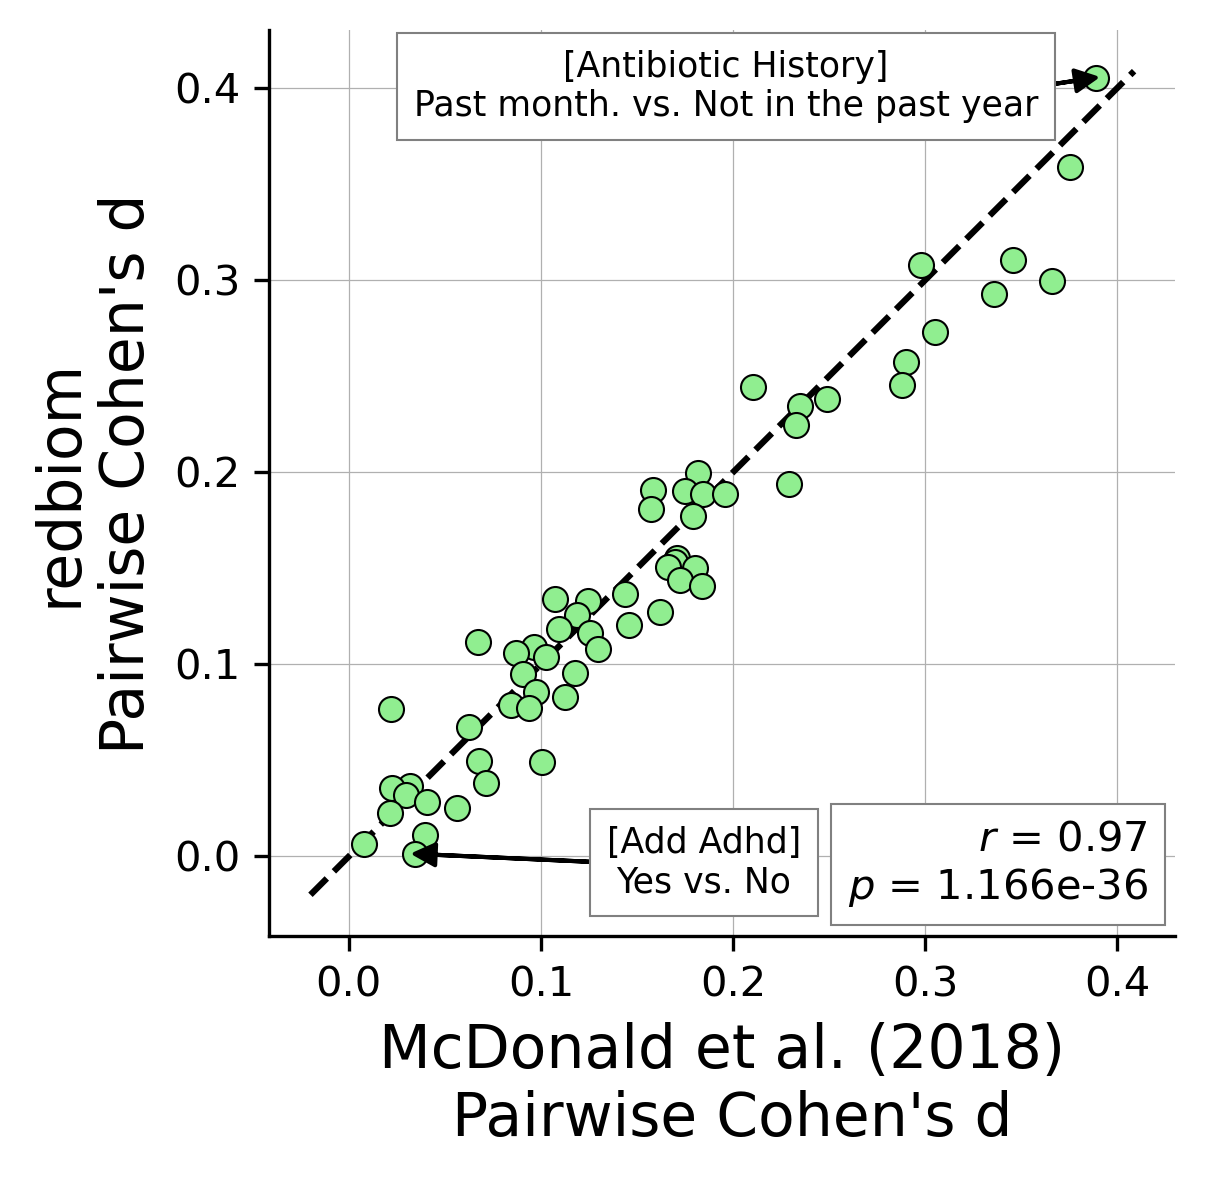

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")

sns.scatterplot(
    data=comp_df_agp_new,
    x="effect_size_agp",
    y="effect_size_evident",
    linewidth=0.5,
    color="lightgreen",
    edgecolor="black",
    zorder=2,
    ax=ax
)

max_val = min(comp_df_agp_new["effect_size_agp"].max(), comp_df_agp_new["effect_size_evident"].max())
ax.plot(
    [0-0.02, max_val+0.02], [0-0.02, max_val+0.02],
    color="black",
    ls="--",
    zorder=1
)

ax.set_xlabel("McDonald et al. (2018)\n Pairwise Cohen's d")
ax.set_ylabel("redbiom\n Pairwise Cohen's d")

bbox = {"facecolor": "white", "alpha": 1, "lw": 0.5, "edgecolor": "gray"}
r, pval = ss.pearsonr(comp_df_agp_new["effect_size_agp"], comp_df_agp_new["effect_size_evident"])
ax.text(
    x=0.97,
    y=0.03,
    s=f"$r$ = {r:.2f}\n$p$ = {pval:.3e}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    bbox=bbox
)

arrowprops = {"facecolor": "black", "width": 0.005, "headwidth": 5, "headlength": 5}
top_cat = comp_df_agp_new.iloc[0]
bot_cat = comp_df_agp_new.iloc[-1]

abx_map = {"I have not taken antibiotics in the past year.": "Not in the past year",
           "Month": "Past month."}

top_cat_name = top_cat.name.replace("_", " ").title()
top_grp1 = abx_map[top_cat.group_1_agp]
top_grp2 = abx_map[top_cat.group_2_agp]
top_text = f"[{top_cat_name}]\n{top_grp1} vs. {top_grp2}"

bot_cat_name = bot_cat.name.replace("_", " ").title()
bot_grp1 = bot_cat.group_1_agp
bot_grp2 = bot_cat.group_2_agp
bot_text = f"[{bot_cat_name}]\n{bot_grp1} vs. {bot_grp2}"

ax.annotate(
    xy=(top_cat["effect_size_agp"], top_cat["effect_size_evident"]),
    xytext=(top_cat["effect_size_agp"] - 0.03, top_cat["effect_size_evident"] - 0.02),
    text=top_text,
    fontsize="small",
    ha="right",
    ma="center",
    arrowprops=arrowprops,
    bbox=bbox
)
ax.annotate(
    xy=(bot_cat["effect_size_agp"], bot_cat["effect_size_evident"]),
    xytext=(bot_cat["effect_size_agp"] + 0.10, bot_cat["effect_size_evident"] - 0.02),
    text=bot_text,
    fontsize="small",
    ha="left",
    ma="center",
    arrowprops=arrowprops,
    bbox=bbox
)

ax.grid(lw=0.3)
ax.set_axisbelow(True)

plt.savefig("../figures/redbiom_vs_published.pdf")
plt.show()

In [13]:
comp_df_agp_new.sort_values(by="es_diff_abs", ascending=False).head()

,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.299894,cohens_d,Asian or Pacific Islander,Caucasian,0.066133,0.066133
acid_reflux,0.021817,0.000476,"Diagnosed by a medical professional (doctor, p...",0.000323,0.0002,Yes,No,0.076880,cohens_d,No,Yes,-0.055064,0.055064
homecooked_meals_frequency,0.100685,0.010137,Daily vs. Occasionally (1-2 times/week),0.000323,0.0002,Daily,Occasionally (1-2 times/week),0.048975,cohens_d,Daily,Occasionally (1-2 times/week),0.051710,0.051710
teethbrushing_frequency,0.067188,0.004514,Regularly (3-5 times/week) vs. Daily,0.000323,0.0002,Regularly (3-5 times/week),Daily,0.111792,cohens_d,Daily,Regularly (3-5 times/week),-0.044604,0.044604
ready_to_eat_meals_frequency,0.183763,0.033769,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.140640,cohens_d,Never,Regularly (3-5 times/week),0.043123,0.043123


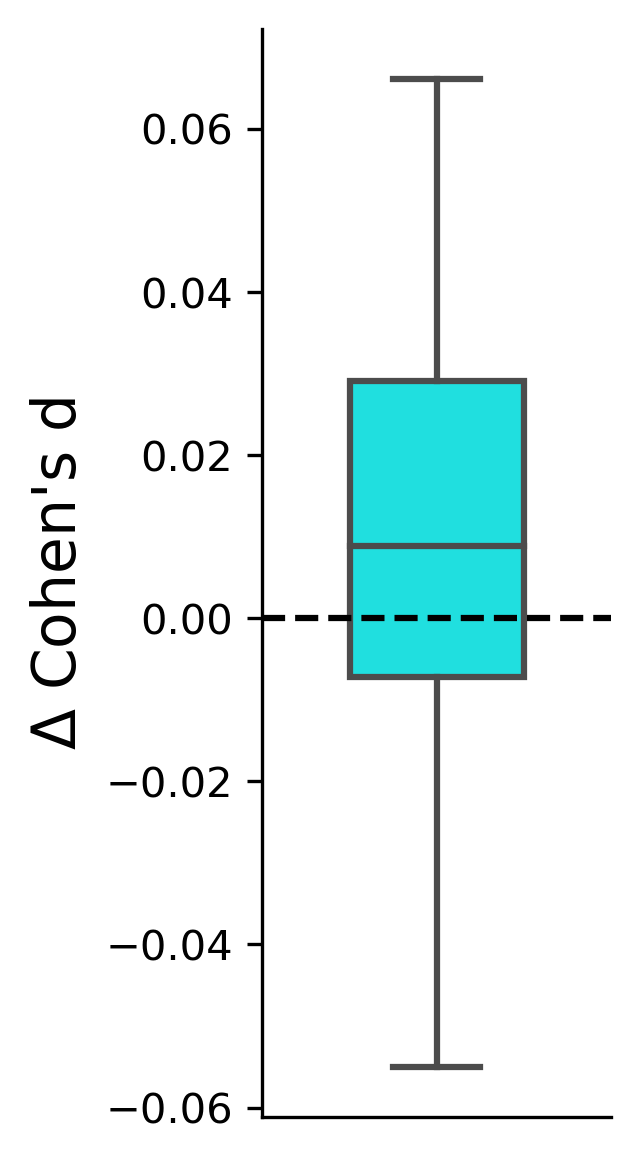

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 4.8))

sns.boxplot(
    y=comp_df_agp_new["es_diff"],
    color="cyan",
    width=0.5,
    ax=ax
)
ax.set_ylabel("$\Delta$ Cohen's d")
ax.tick_params("x", width=0)
ax.axhline(0, ls="--", color="black")

plt.savefig("../figures/redbiom_vs_published_boxplot.pdf")
plt.show()

In [15]:
es_df = pd.read_table("../results/beta_effect_size_by_cat.tsv", sep="\t", index_col=0).dropna()
es_df = es_df[es_df["column"].isin(common_cols)]
print(es_df.shape)
es_df.head(10)

(61, 3)


,effect_size,metric,column
0,0.257566,cohens_d,fungal_overgrowth
1,0.188776,cohens_d,autoimmune
2,0.177345,cohens_d,clinical_condition
4,0.155342,cohens_d,other_supplement_frequency
5,0.136793,cohens_d,lactose
8,0.125901,cohens_d,multivitamin
11,0.095584,cohens_d,nail_biter
13,0.078974,cohens_d,ibs
14,0.076880,cohens_d,acid_reflux
20,0.038303,cohens_d,acne_medication_otc


In [16]:
es_df["metric"].value_counts()

cohens_f    46
cohens_d    15
Name: metric, dtype: int64

In [17]:
pa_df = pd.read_table("../results/power_analysis.tsv", sep="\t")
pa_df = pa_df[pa_df["column"].isin(common_cols)]
print(pa_df.shape)
pa_df.head()

(6954, 7)


,alpha,total_observations,power,effect_size,difference,metric,column
0,0.01,20,0.010118,0.02164,NaN,cohens_f,vegetable_frequency
1,0.05,20,0.050435,0.02164,NaN,cohens_f,vegetable_frequency
2,0.10,20,0.100711,0.02164,NaN,cohens_f,vegetable_frequency
3,0.01,60,0.010449,0.02164,NaN,cohens_f,vegetable_frequency
4,0.05,60,0.051537,0.02164,NaN,cohens_f,vegetable_frequency


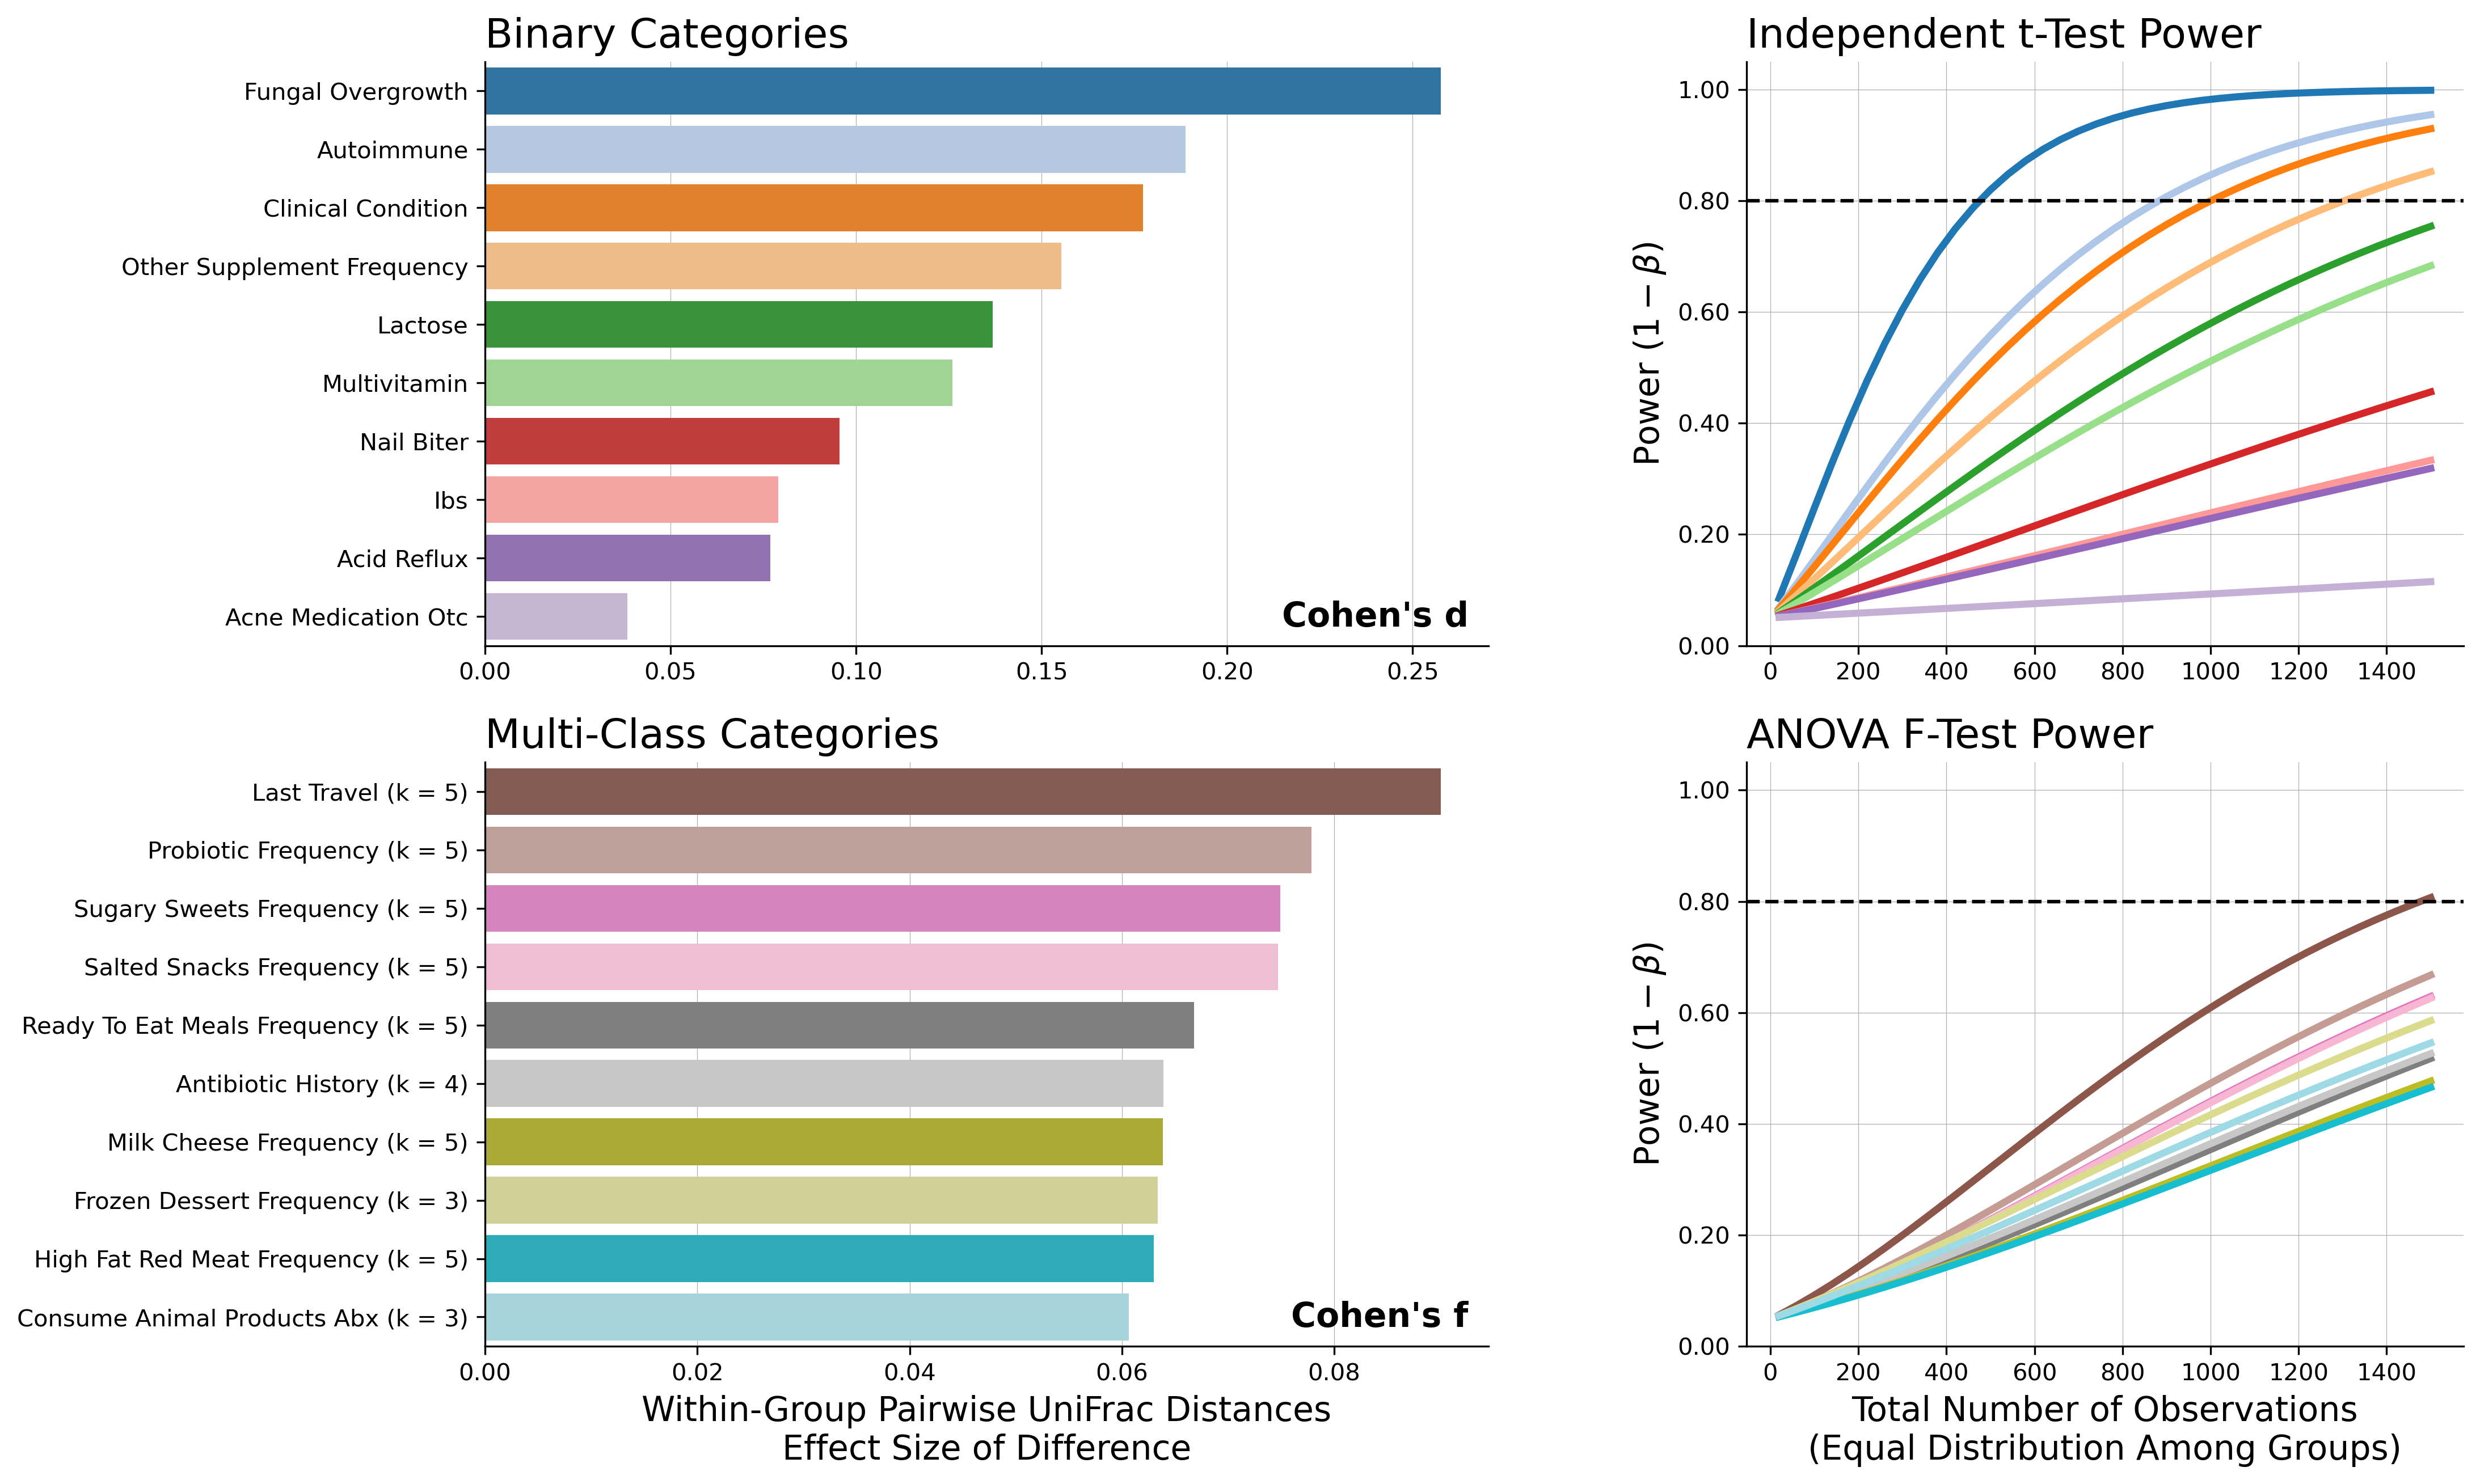

In [18]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.4, 1], hspace=0.2, wspace=0.3)
bar_ax_d, pwr_ax_d = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
bar_ax_f, pwr_ax_f = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])

n = 10
alpha = 0.05

_es_df_d = es_df.query("metric == 'cohens_d'").head(n)
order_d = _es_df_d["column"]

_es_df_f = es_df.query("metric == 'cohens_f'").head(n)
order_f = _es_df_f["column"]

_pa_df_d = pa_df.query("metric == 'cohens_d' & alpha == @alpha")
_pa_df_d = _pa_df_d[_pa_df_d["column"].isin(order_d)]

_pa_df_f = pa_df.query("metric == 'cohens_f' & alpha == @alpha")
_pa_df_f = _pa_df_f[_pa_df_f["column"].isin(order_f)]

top_cols = order_d.tolist() + order_f.tolist()
cmap = dict(zip(top_cols, sns.color_palette("tab20", n*2)))

bar_args = {"y": "column", "x": "effect_size", "palette": cmap}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.barplot(**bar_args, data=_es_df_d, ax=bar_ax_d)
bar_ax_d.set_xlabel("")
bar_ax_d.text(**text_args, s="Cohen's d", transform=bar_ax_d.transAxes)

sns.barplot(**bar_args, data=_es_df_f, ax=bar_ax_f)
bar_ax_f.text(**text_args, s="Cohen's f", transform=bar_ax_f.transAxes)
bar_ax_f.set_xlabel("Within-Group Pairwise UniFrac Distances\nEffect Size of Difference")

for ax in [bar_ax_d, bar_ax_f]:
    new_labels = []
    for ytick_label in ax.get_yticklabels():
        text = ytick_label.get_text()
        k = len(df_new[text].dropna().unique())
        text = text.replace("_", " ").title()
        if k > 2:
            text += f" (k = {k})"
        new_labels.append(text)
    ax.set_yticklabels(new_labels)
    ax.set_ylabel("")

## Power
line_args = {"y": "power", "x": "total_observations", "palette": cmap, "hue": "column",
             "lw": 3, "legend": False}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.lineplot(**line_args, data=_pa_df_d, ax=pwr_ax_d, hue_order=order_d)
pwr_ax_d.set_xlabel("")

sns.lineplot(**line_args, data=_pa_df_f, ax=pwr_ax_f, hue_order=order_f)
pwr_ax_f.set_xlabel("Total Number of Observations\n(Equal Distribution Among Groups)")

for ax in [pwr_ax_d, pwr_ax_f]:
    ax.set_ylabel(r"Power $(1 - \beta)$")
    ax.grid(axis="both")
    ax.set_axisbelow(True)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.axhline(0.8, color="black", ls="--")
    ax.set_ylim([0, 1.05])
    
for ax in [bar_ax_d, bar_ax_f]:
    ax.grid(axis="x")
    
for ax in [bar_ax_d, bar_ax_f, pwr_ax_d, pwr_ax_f]:
    ax.set_axisbelow(True)
    ax.tick_params("both")
    ax.set_xlabel(ax.get_xlabel())
    
bar_ax_d.set_title("Binary Categories")
bar_ax_f.set_title("Multi-Class Categories")

pwr_ax_d.set_title("Independent t-Test Power")
pwr_ax_f.set_title("ANOVA F-Test Power")

plt.savefig("../figures/effect_sizes_and_power.pdf")
plt.show()

In [19]:
dm = DistanceMatrix.read("../results/distance-matrix-u_unifrac.tsv")

In [20]:
top_binary_cat = (
    es_df[es_df["metric"] == "cohens_d"]
    .sort_values(by="effect_size", ascending=False)
    .iloc[0]
)
grp1_name, grp2_name = df_new[top_binary_cat.column].dropna().unique()
col_name = top_binary_cat.column
grp1 = df_new[df_new[col_name] == grp1_name]
grp2 = df_new[df_new[col_name] == grp2_name]

grp1_vals = dm.filter(grp1.index, strict=False).to_series().values
grp2_vals = dm.filter(grp2.index, strict=False).to_series().values

In [22]:
top_multi_class_cat = (
    es_df[es_df["metric"] == "cohens_f"]
    .sort_values(by="effect_size", ascending=False)
    .iloc[0]
)
mc_col_name = top_multi_class_cat.column
mc_grp_dict = dict()

for grp_name in df_new[mc_col_name].dropna().unique():
    print(grp_name)
    _grp_df = df_new[df_new[mc_col_name] == grp_name]
    if grp_name == "I have not been outside of my country of residence in the past year.":
        grp_name = "Not in past year"
    _grp_values = dm.filter(_grp_df.index, strict=False).to_series().values
    
    mc_grp_dict[grp_name] = {
        "values": _grp_values,
        "df": _grp_df,
    }

3 months
I have not been outside of my country of residence in the past year.
6 months
1 year
Month


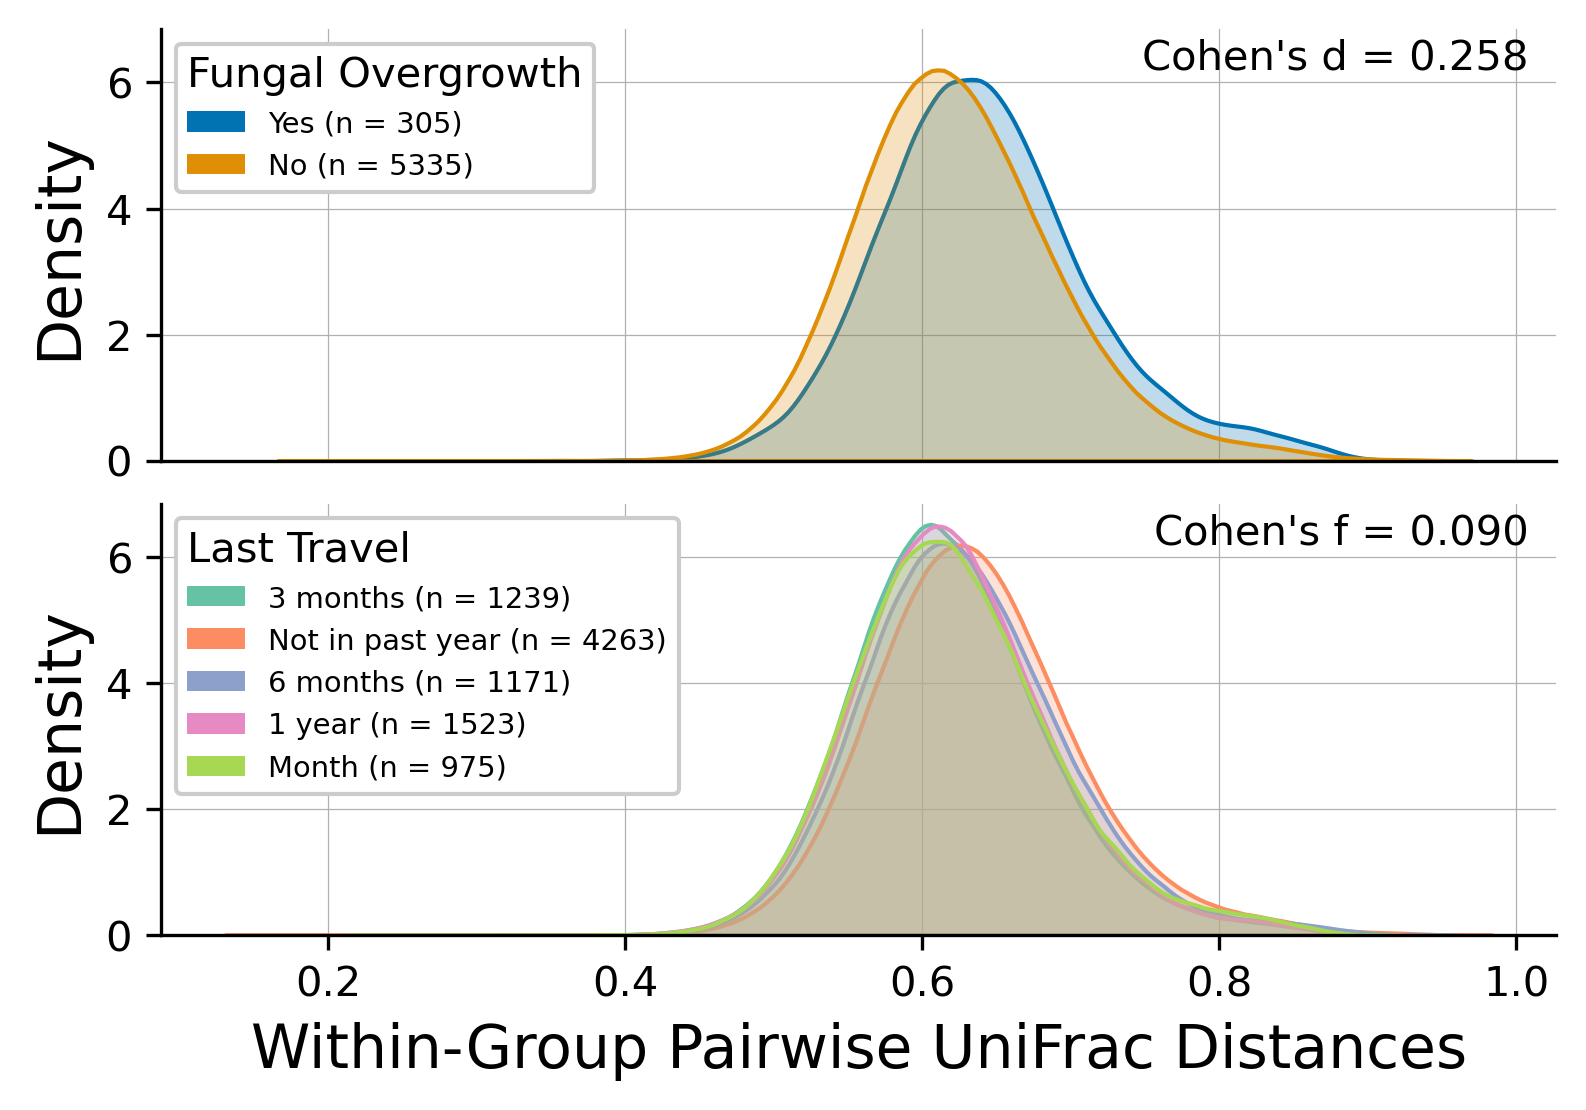

CPU times: user 1min 57s, sys: 4.06 s, total: 2min 2s
Wall time: 1min 56s


In [23]:
%%time

from matplotlib.patches import Patch

fig, axs = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax1 = axs[0]
ax2 = axs[1]

grp1_color, grp2_color = sns.color_palette("colorblind", 2)

colors = [grp1_color, grp2_color]
for grp_values, color in zip([grp1_vals, grp2_vals], colors):
    sns.kdeplot(
        data=grp_values,
        color=color,
        fill=True,
        ax=ax1
    )

ax1.set_ylabel("Density")
ax1.tick_params("x", width=0)

grp1_patch = Patch(facecolor=grp1_color, label=f"{grp1_name} (n = {grp1.shape[0]})")
grp2_patch = Patch(facecolor=grp2_color, label=f"{grp2_name} (n = {grp2.shape[0]})")

leg = ax1.legend(
    handles=[grp1_patch, grp2_patch],
    title=col_name.replace("_", " ").title(),
    loc="upper left",
    framealpha=1
)
leg._legend_box.align = "left"

es = es_df[es_df["column"] == col_name]["effect_size"].item()
ax1.text(
    x=0.98,
    y=0.98,
    s=f"Cohen's d = {es:.3f}",
    transform=ax1.transAxes,
    ha="right",
    va="top",
)

mc_color_dict = dict(zip(mc_grp_dict.keys(), sns.color_palette("Set2", len(mc_grp_dict))))

mc_patches = []
for grp_name, grp_dict in mc_grp_dict.items():
    sns.kdeplot(
        grp_dict["values"],
        color=mc_color_dict[grp_name],
        fill=True,
        ax=ax2
    )
    _n = grp_dict["df"].shape[0]
    _patch = Patch(
        facecolor=mc_color_dict[grp_name],
        label=f"{grp_name} (n = {_n})"
    )
    mc_patches.append(_patch)
    
ax2.set_ylabel("Density")
ax2.set_xlabel("Within-Group Pairwise UniFrac Distances")

leg = ax2.legend(
    handles=mc_patches,
    title=mc_col_name.replace("_", " ").title(),
    loc="upper left",
    framealpha=1
)
leg._legend_box.align = "left"

es = es_df[es_df["column"] == mc_col_name]["effect_size"].item()
ax2.text(
    x=0.98,
    y=0.98,
    s=f"Cohen's f = {es:.3f}",
    transform=ax2.transAxes,
    ha="right",
    va="top",
)

y_max = max([ax1.get_ylim()[1], ax2.get_ylim()[1]])

for ax in axs:
    ax.set_ylim([0, y_max])
    ax.grid()
    ax.set_axisbelow(True)

plt.savefig("../figures/top_cats_distances_combined.pdf")
plt.show()